In [1]:
from Annau2022.models import generator, critic
from Annau2022.SRModel import SRModelData, SuperResolver
from Annau2022.RAPSD import compute_rapsd

import itertools
import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import geopandas as gpd

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}'
    })


In [2]:
model_list = {
    "southeast": [
        SRModelData(region="southeast", sr_model_name="CNN", exp_id="e25c6b40324643c3afc1cf42981b11b5"),
        SRModelData(region="southeast", sr_model_name="L_5", exp_id="1824682ae27c48669665cf042052d584"),
        SRModelData(region="southeast", sr_model_name="L_9", exp_id="3f48868c52404eb0a833897aa4642871"),
        SRModelData(region="southeast", sr_model_name="L_13", exp_id="e1d15a0615ca489aa6a17ec60247d0af"),
        SRModelData(region="southeast", sr_model_name="NFS", exp_id="feda42500d2b45549be96f1bf62b0b03"),
    ],
    "central": [
        SRModelData(region="central", sr_model_name="CNN", exp_id="fbe44b0423204805bc6af4d7d6ac562e"),
        SRModelData(region="central", sr_model_name="L_5", exp_id="202ea9f8a73b401fa22e62c24d9ab2d0"),
        SRModelData(region="central", sr_model_name="L_9", exp_id="079a94c41ad3482996cc2b9f95adba8d"),
        SRModelData(region="central", sr_model_name="L_13", exp_id="bcf7e7cfa8ab4c4196ad6a2bb18e8601"),
        SRModelData(region="central", sr_model_name="NFS", exp_id="0c5ee480663f4f9eb7200f8879aa1244"),
    ],
    "west": [
        SRModelData(region="west", sr_model_name="CNN", exp_id="f76c0170818244629de4544805f93a59"),
        SRModelData(region="west", sr_model_name="L_5", exp_id="70f5be887eff42e8a216780752644b2f"),
        SRModelData(region="west", sr_model_name="L_9", exp_id="6abe7a9940c04b47819689070100e5e6"),
        SRModelData(region="west", sr_model_name="L_13", exp_id="c4ec13e65fe74b399fc9e325a9966fef"),
        SRModelData(region="west", sr_model_name="NFS", exp_id="db9f0fae83c949eaad5d1176a43dae47"),
    ]
}

In [3]:
physical_extent_wrf = {
    # lon min, lon max, lat min, lat max
    "southeast":[-86.55435944, -74.64796448, 21.13699913, 33.04325104],
    "central": [-101.55454254, -89.64814758, 40.63700104, 52.54325104],
    "west": [-127.80486298, -115.89846802, 40.63700104, 52.54325104]
}

physical_extent_era = {
    "southeast": [-86.55435944, -75.30422211, 21.13699913, 32.38700104],
    "central": [-101.55454254, -90.30440521, 40.63700104, 51.88700104],
    "west": [-127.80486298, -116.55472565, 40.63700104, 51.88700104],
}

In [4]:
# Load shapefiles of North America
cultural = gpd.read_file("/workspace/Annau2022/data/shapefiles/ne_10m_admin_0_countries.shp")
cultural = cultural[((cultural.ADMIN == "Canada") | (cultural.ADMIN == "United States of America") | (cultural.ADMIN == "Cuba"))].boundary
# Only use largest lakes
lakes = gpd.read_file("/workspace/Annau2022/data/shapefiles/ne_10m_lakes.shp")
lakes = lakes[lakes.scalerank <= 2].boundary
shape = cultural.geometry.append(lakes.geometry)

### Process the models and store them in a dictionary

In [5]:
idx = 17

figure_fields = {}

var_ref = {"u10":0, "v10":1}
var_name = "u10"

for region in model_list:
    figure_fields[region] = {}
    for model in model_list[region]:
        lr, hr = model.load_test()
        generator = model.load_generator()
        sr = SuperResolver(region=region, lr=lr, hr=hr, model=generator)
        
        # Process realizations
        sr_field = next(itertools.islice(sr.super_resolve(), idx, None)).cpu().detach().numpy()
        wrf = next(itertools.islice(sr.ground_truth(), idx, None)).cpu().detach().numpy()

        # Denormalize LR models based on stats from sr object for the region
        lr_denorm = sr.denormalise(lr, sr.load_stats_json())
        figure_fields[region]["ERA"] = lr_denorm[idx, var_ref[var_name], ...].cpu().detach().numpy()
        
        # Extract variable and field dimensions into 2D tensor
        figure_fields[region][model.sr_model_name] = sr_field[0, var_ref[var_name], ...]

    # Add ground truth to dictionary
    figure_fields[region]["ground_truth"] = wrf[0, var_ref[var_name], ...]


  0%|          | 0/3 [00:00<?, ?it/s]

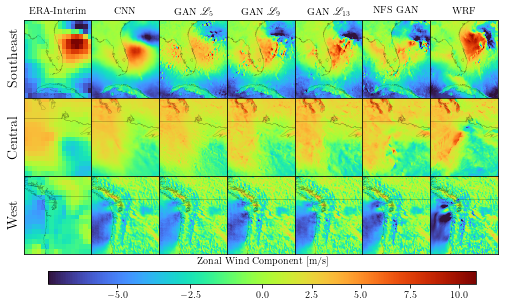

In [6]:
fig, axes = plt.subplots(3, 7, figsize=(8.5, 3.7))
cmap = "turbo"

vmin = -7.3944
vmax = 10.8726
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

titlemap = {
    "CNN": "CNN",
    "L_5": r"GAN $\mathscr{L}_5$",
    "L_9": r"GAN $\mathscr{L}_9$",
    "L_13": r"GAN $\mathscr{L}_{13}$",
    "NFS": "NFS GAN",
    "ground_truth": "WRF",
    "ERA": "ERA-Interim"
}

for i, region in enumerate(figure_fields):
    for j, sr_model_name in enumerate(figure_fields[region]):

        if "ERA" in sr_model_name:
            extent = physical_extent_era[region]
        else:
            extent = physical_extent_wrf[region]

        axes[0, j].set_title(f"{titlemap[sr_model_name]}", fontsize=10)
        im = axes[i, j].imshow(
            figure_fields[region][sr_model_name],
            extent = extent,
            cmap = "turbo",
            origin="lower",
            norm=divnorm
        )
        axes[i, 0].set_ylabel(region.capitalize(), fontsize=14)
        shape.plot(ax = axes[i, j], color="black", linewidth=0.1)
        axes[i, j].set_xlim(extent[0], extent[1])
        axes[i, j].set_ylim(extent[2], extent[3])

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    
fig.subplots_adjust(bottom=0.0)
cbar_ax = fig.add_axes([0.165, -0.111, 0.7, 0.05])
cbar_ax.tick_params(labelsize=10)
cb = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cb.ax.set_title('Zonal Wind Component [m/s]',fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0)